<a href="https://colab.research.google.com/github/gogogo191/mediametadata/blob/main/maskedking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import urllib.request
import zipfile
import numpy as np
from IPython.display import Image

In [2]:
# 구글드라이브 연동
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

Found 111 images belonging to 3 classes.
(111, 45, 430, 3) (111, 3)
[0. 0. 1.]


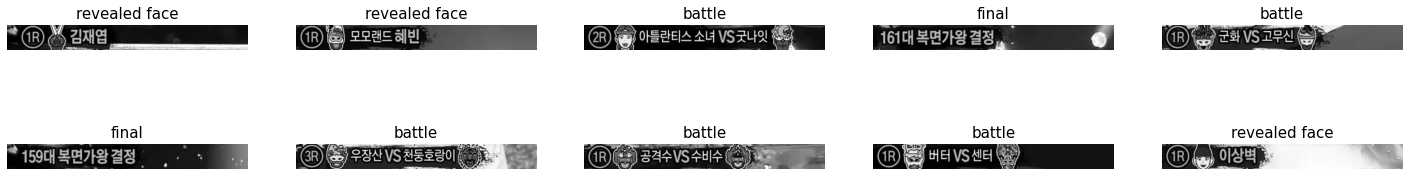

In [4]:
import matplotlib.pyplot as plt

path = '/content/gdrive/MyDrive/opencv프로젝트/분류제목이미지'

class_map = {
    0: 'final',
    1: 'battle',
    2: 'revealed face',
}

original_datagen = ImageDataGenerator(rescale=1./255)
original_generator = original_datagen.flow_from_directory(path, 
                                                          batch_size=128, 
                                                          target_size=(45, 430), 
                                                          class_mode='categorical'

                                                         )

for x, y in original_generator:
    print(x.shape, y.shape)
    print(y[0])
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(25, 4)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
        axes[i//5, i%5].axis('off')
    break
plt.show()

In [5]:
TRAINING_DIR = path
VALIDATION_DIR = '/content/gdrive/MyDrive/opencv프로젝트/검증용이미지'

In [6]:
training_datagen = ImageDataGenerator(rescale=1. / 255,
                                      validation_split=0.2)

In [7]:
training_generator = training_datagen.flow_from_directory(TRAINING_DIR, 
                                                          batch_size=128, 
                                                          target_size=(45, 430), 
                                                          class_mode='categorical', 
                                                          subset='training',
                                                         )

validation_generator = training_datagen.flow_from_directory(TRAINING_DIR, 
                                                          batch_size=128, 
                                                          target_size=(45, 430), 
                                                          class_mode='categorical',
                                                          subset='validation', 
                                                         )

Found 90 images belonging to 3 classes.
Found 21 images belonging to 3 classes.


(90, 45, 430, 3) (90, 3)
[0. 0. 1.]


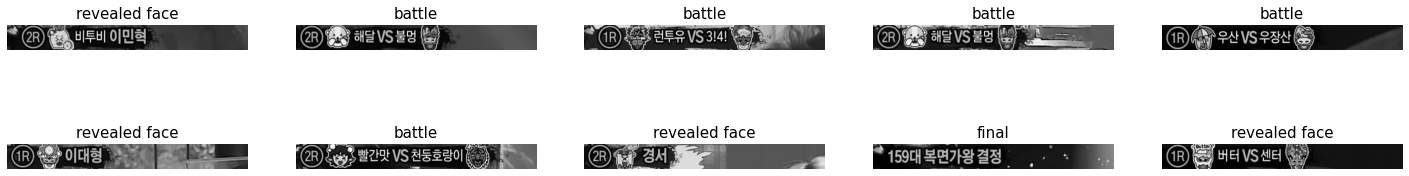

In [8]:
for x, y in training_generator:
    print(x.shape, y.shape)
    print(y[0])

    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(25, 4)
    
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
        axes[i//5, i%5].axis('off')
    break

for x, y in original_generator:
    pic = x[:5]
    break

plt.imshow(pic[0])

In [9]:
conv2d = Conv2D(64, (3, 3), input_shape=(45, 430, 3))
conv2d_activation = Conv2D(64, (3, 3), activation='relu', input_shape=(45, 430, 3))

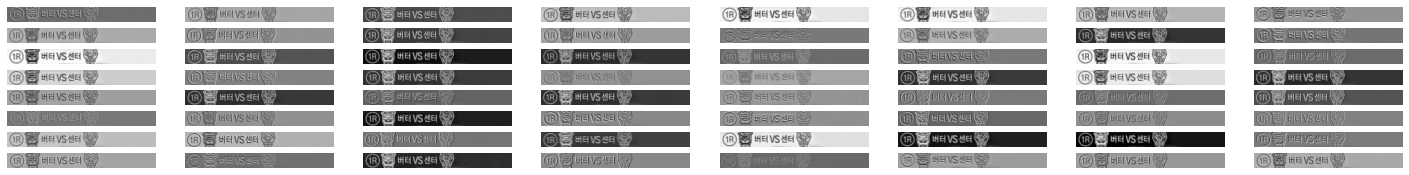

In [10]:
fig, axes = plt.subplots(8, 8)
fig.set_size_inches(25, 3)
for i in range(64):
    axes[i//8, i%8].imshow(conv2d(pic)[0,:,:,i], cmap='gray')
    axes[i//8, i%8].axis('off')

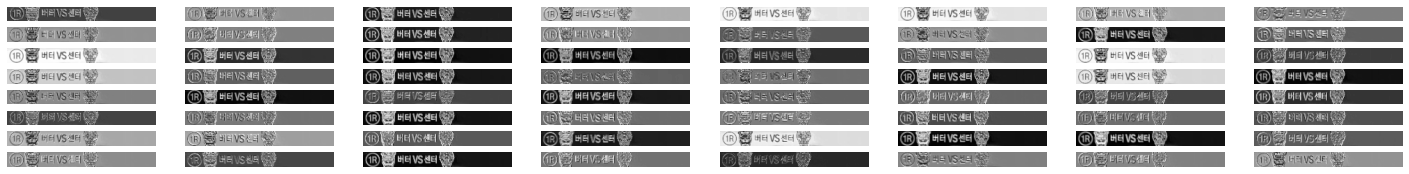

In [11]:
fig, axes = plt.subplots(8, 8)
fig.set_size_inches(25, 3)
for i in range(64):
    axes[i//8, i%8].imshow(MaxPooling2D(2, 2)(conv2d(pic))[0, :, :, i], cmap='gray')
    axes[i//8, i%8].axis('off')

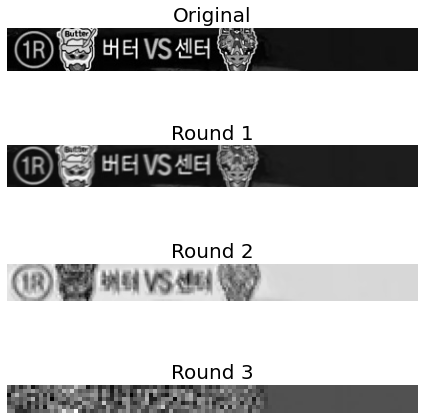

In [12]:
conv1 = Conv2D(64, (3, 3), input_shape=(45, 430, 3))(pic)
max1 = MaxPooling2D(2, 2)(conv1)
conv2 = Conv2D(64, (3, 3))(max1)
max2 = MaxPooling2D(2, 2)(conv2)
conv3 = Conv2D(64, (3, 3))(max2)
max3 = MaxPooling2D(2, 2)(conv3)

fig, axes = plt.subplots(4, 1)
fig.set_size_inches(6, 7)
axes[0].set_title('Original', fontsize=20)
axes[0].imshow(pic[0])
axes[0].axis('off')
axes[1].set_title('Round 1', fontsize=20)
axes[1].imshow( conv1[0, :, :, 0], cmap='gray')
axes[1].axis('off')
axes[2].set_title('Round 2', fontsize=20)
axes[2].imshow( conv2[0, :, :, 0], cmap='gray')
axes[2].axis('off')
axes[3].set_title('Round 3', fontsize=20)
axes[3].imshow( conv3[0, :, :, 0], cmap='gray')
axes[3].axis('off')
plt.tight_layout()
plt.show()

In [13]:
model = Sequential([
    # Conv2D, MaxPooling2D 조합으로 층을 쌓습니다. 첫번째 입력층의 input_shape은 (150, 150, 3)으로 지정합니다.
    Conv2D(64, (3, 3), activation='relu', input_shape=(45, 430, 3)),
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    # Conv2D(128, (3, 3), activation='relu'),
    # MaxPooling2D(2, 2), 
    # Conv2D(128, (3, 3), activation='relu'),
    # MaxPooling2D(2, 2), 
    Flatten(), 
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax'),
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 43, 428, 64)       1792      
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 21, 214, 64)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 19, 212, 64)       36928     
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 9, 106, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61056)             0         
_________________________________________________________________
dropout (Dropout)            (None, 61056)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [16]:
checkpoint_path = "tmp_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [17]:
history = model.fit(training_generator,
                    validation_data=(validation_generator),
                    epochs=25,
                    callbacks=[checkpoint],
                    )

Epoch 1/25
1/1 [==============================] - 6s 6s/step - loss: 1.1746 - acc: 0.2000 - val_loss: 2.9428 - val_acc: 0.6667

Epoch 00001: val_loss improved from inf to 2.94276, saving model to tmp_checkpoint.ckpt
Epoch 2/25
1/1 [==============================] - 4s 4s/step - loss: 2.7561 - acc: 0.6556 - val_loss: 1.0712 - val_acc: 0.6667

Epoch 00002: val_loss improved from 2.94276 to 1.07121, saving model to tmp_checkpoint.ckpt
Epoch 3/25
1/1 [==============================] - 4s 4s/step - loss: 1.1074 - acc: 0.6556 - val_loss: 0.9434 - val_acc: 0.2857

Epoch 00003: val_loss improved from 1.07121 to 0.94336, saving model to tmp_checkpoint.ckpt
Epoch 4/25
1/1 [==============================] - 4s 4s/step - loss: 1.0981 - acc: 0.2667 - val_loss: 0.7091 - val_acc: 0.5714

Epoch 00004: val_loss improved from 0.94336 to 0.70915, saving model to tmp_checkpoint.ckpt
Epoch 5/25
1/1 [==============================] - 4s 4s/step - loss: 0.7892 - acc: 0.6111 - val_loss: 0.5327 - val_acc: 0.85

In [ ]:
model.load_weights(checkpoint_path)

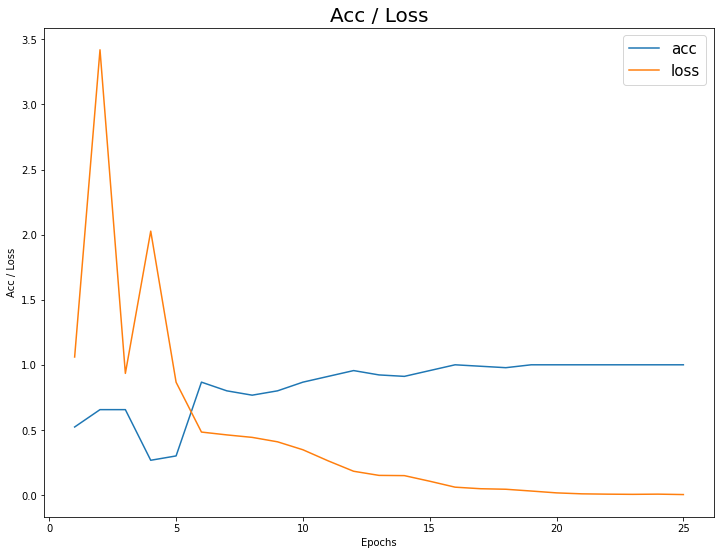

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, 26), history.history['acc'])
plt.plot(np.arange(1, 26), history.history['loss'])
plt.title('Acc / Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Acc / Loss')
plt.legend(['acc', 'loss'], fontsize=15)
plt.show()